# Can CNNs time travel?
> What impact does the time period of images have on the accuracy of our models?

In [ ]:
# all_slow

In the previous notebook, we created a sample and annotated this data. Since we want to create a classifier to help us understand a historical phenomenon, i.e. the use of visuals in newspaper advertising, we must see how robust our model is across the period of our data.

Since we have quite an extensive date range (1850-1950), we want to ensure that our model doesn't do *significantly* worse on some years. If it does do particularly badly on some years, we may draw mistaken conclusions about the historical trends we're trying to detect through our classifier. 

First we start with some imports. From `nnanno` we import one function

In [ ]:
from nnanno.annotate import check_download_df_match

We import fastai and some callbacks for our model training 

In [ ]:
from fastai.callback import *
from fastai.vision.all import *

We import a few extra libraries for helping with plotting 

In [ ]:
from pathlib import Path
import matplotlib
import pandas as pd

In [ ]:
matplotlib.style.use("seaborn-notebook")

## Load the data

First we'll start by loading the data

In [ ]:
# TODO add download link to ads data

We'll load the JSON file containing our annotated data. If you need a reminder of where this came from,  refer to the previous notebook in this series where this data was created. 

In [ ]:
json_file = list(Path("data/images/").rglob("*.json"))[0]

In [ ]:
df = pd.read_json(json_file)

We can use a small function from nnano to check that the number of images we have matches our dataframe

In [ ]:
check_download_df_match("data/images/", df)

Length of DataFrame 1085 and number of images in data/images/ 1085 match 😀


### Create date info

Since we're going to be working with dates extensively, we'll want to make sure we can easily filter by this field. We can parse the  `pub_date` column into a pandas datetime column. We can then use this to grab the year. 

In [ ]:
df.pub_date = pd.to_datetime(df.pub_date)

In [ ]:
df.pub_date.dt.year

0       1920
1       1910
2       1880
3       1890
4       1930
        ... 
1080    1900
1081    1850
1082    1930
1083    1860
1084    1890
Name: pub_date, Length: 1085, dtype: int64

We can also put year in a new column 

In [ ]:
df["year"] = df.pub_date.dt.year

## Evaluating decade accuracy

To see if our model will perform worse on some years, we'll train a model on the entire dataset and the run predictions on a subset and see if particular years perform worse. 

Some years may be 'harder' for the model regardless of the training data. For example, the newspaper for some years might have been subject to damage. These biases might be systematic, or the might be random, trying out the model across all years will give us a way of roughly checking this. 

First we import `train_test_split` from sklearn to help us prepare subsamples

In [ ]:
from sklearn.model_selection import train_test_split

We now want to create a train and valid sample. We pass in the `stratify` option to make sure we get equal splits by year

In [ ]:
train, valid_test = train_test_split(
    df.copy(), test_size=600, stratify=df.pub_date.dt.year
)

We split `valid_test` into a 'validation' and 'test' set

In [ ]:
valid, test_df = train_test_split(
    valid_test.copy(), test_size=400, stratify=valid_test.pub_date.dt.year
)

Check the sizes of these

In [ ]:
len(train), len(valid), len(test_df)

(485, 200, 400)

We can confirm this is roughly even accross years

In [ ]:
train.pub_date.dt.year.value_counts()

1850    45
1860    44
1870    44
1880    44
1890    44
1900    44
1910    44
1920    44
1930    44
1940    44
1950    44
Name: pub_date, dtype: int64

and with valid

In [ ]:
valid.pub_date.dt.year.value_counts()

1890    19
1930    19
1850    18
1860    18
1870    18
1880    18
1900    18
1910    18
1920    18
1940    18
1950    18
Name: pub_date, dtype: int64

This looks good enough. There is a difference of 1 between some years but this *probably* isn't going to make a big difference. Now we can get to the training part. 

As with the rest of the examples, we'll use fastai since it helps us experiment quickly and focus on the questions we're interested in exploring in this case. 

Since we're going to be training multiple models, its helpful to define metrics once as a variable that we can pass into our model. This means we can change all the metrics for the model by changing this line. 

In [ ]:
METRICS = [F1Score(average="micro"), Precision(), Recall(), accuracy]

We now add an extra `is_valid` column to our train and valid DataFrames. This means we can then quickly pass the entire DataFrame to fastai

In [ ]:
train["is_valid"] = False
valid["is_valid"] = True
df = pd.concat([train, valid])
df.reset_index(drop=True, inplace=True)

If you have followed the Programming Historian lesson, we always loaded the data via fastai 'factory' methods. One of the beautiful things about the fastai API is that it is layered and we can easily jump 'down' a layer to get more control when needed. One way we can do this is with the DataBlocK API. You can read more about this API in the DataBlock [tutorial](https://docs.fast.ai/tutorial.datablock.html).

A tl;dr summary of the DataBlock API;  it allows us to define how we want to load our data by specifying various pipeline components. For example `get_y` is used to say how the labels should be loaded, `splitter` is used to define how we split our data. 

In [ ]:
full_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=ColReader("download_image_path", pref="data/images/"),
    get_y=ColReader("label"),
    item_tfms=Resize(224),
)

We can use this 'template' for loading our data with different DataFrames. Let's load all of this data and have a quick look to see everything looks okay. So far, we have only created a `DataBlock` this is a 'framework' for loading our data. To do the actual loading, we'll use the dataloaders method

In [ ]:
dls = full_data.dataloaders(df, bs=8, num_workers=0)

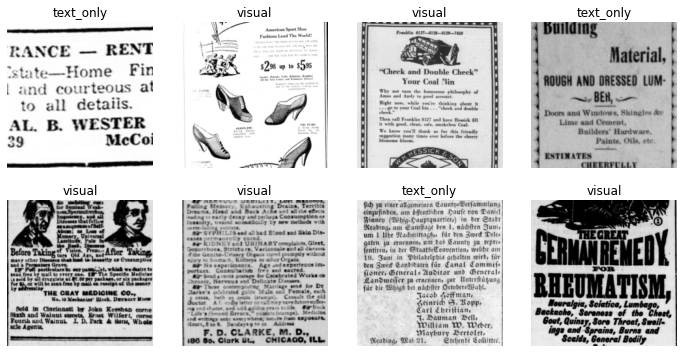

In [ ]:
dls.show_batch()

### Train

Now we'll create a model and train it using two callbacks. `SaveModelCallback` will keep track of our best model monitoring `f1_score` at the end of the training, it will return the best performing model. `EarlyStoppingCallback` will stop the model after a set amount of `patience` (i.e. epochs during which there is no improvement). 

In [ ]:
learn = cnn_learner(
    dls, resnet18, metrics=METRICS, cbs=SaveModelCallback(monitor="f1_score")
)

In [ ]:
with learn.no_bar():
    learn.fine_tune(10, cbs=EarlyStoppingCallback(patience=4, monitor="f1_score"))

[0, 1.0556607246398926, 0.5932126045227051, 0.82, 0.7540983606557377, 0.6865671641791045, 0.8199999928474426, '01:38']
Better model found at epoch 0 with f1_score value: 0.82.
[0, 0.6927639245986938, 0.39137476682662964, 0.85, 0.7534246575342466, 0.8208955223880597, 0.8500000238418579, '02:01']
Better model found at epoch 0 with f1_score value: 0.85.
[1, 0.6032361388206482, 0.44139033555984497, 0.83, 0.7323943661971831, 0.7761194029850746, 0.8299999833106995, '01:58']
[2, 0.5202495455741882, 0.3638007342815399, 0.9, 0.9122807017543859, 0.7761194029850746, 0.8999999761581421, '02:06']
Better model found at epoch 2 with f1_score value: 0.9.
[3, 0.5379711985588074, 0.43496429920196533, 0.89, 0.8947368421052632, 0.7611940298507462, 0.8899999856948853, '02:06']
[4, 0.4739179015159607, 0.3054388463497162, 0.89, 0.8688524590163934, 0.7910447761194029, 0.8899999856948853, '02:07']
[5, 0.34291085600852966, 0.33337584137916565, 0.9, 0.8983050847457628, 0.7910447761194029, 0.8999999761581421, '02

### Prediction

We can now take a look at our models predictions. First we create a test data loader. We can do this using the `dls.test_dl` and passing in our test_df

In [ ]:
test_data = learn.dls.test_dl(test_df)

Using `test_dl` ensures that we the same 'transforms' are used for loading our data for testing as was used during the training process. It's beyond the scope of this notebook to fully cover transforms in fastai, but we can take a look at what these are doing in this example

In [ ]:
test_data.transform

PILBase.create:
encodes: (Path,object) -> create
(str,object) -> create
(Tensor,object) -> create
(ndarray,object) -> create
(bytes,object) -> createdecodes: 

We can now use this test data to get some predictions using `get_preds`. 

In [ ]:
preds = learn.get_preds(dl=test_data, with_decoded=True)

If we take a look at the type returned you'll see we get a tuple back of length 3

In [ ]:
type(preds), len(preds)

(tuple, 3)

If we look at the first tuple (slicing the first few examples) you'll see we have a tensor with two columns. As you might guess each of these is a columns is the probability for one of the possible labels

In [ ]:
preds[0][:5]

tensor([[9.6654e-01, 3.3461e-02],
        [3.6108e-04, 9.9964e-01],
        [2.6035e-03, 9.9740e-01],
        [9.9840e-01, 1.6020e-03],
        [9.8257e-01, 1.7429e-02]])

The second tuple value is empty (we'll ignore why for now)

In [ ]:
preds[1]

the last value has a tensor with 0 and 1, this is the predicted label for each possible value. 

In [ ]:
preds[2][:5]

tensor([0, 1, 1, 0, 0])

We now want to check whether these are correct. You'll notice that the decoded predictions don't contain our actual labels. We can quicky conver these using a list comphrension. We can access the vocab from our learner to check which order the labels are

In [ ]:
learn.dls.vocab

['text_only', 'visual']

In [ ]:
pred_str = ["text_only" if y == 0 else "visual" for y in preds[2].tolist()]
pred_str[:3]

['text_only', 'visual', 'visual']

Now we can see where the predicted label matches the true label

In [ ]:
test_df["correct"] = test_df["label"] == pred_str

We get back a new column which contains `True` or `False` depending on whether the prediction was correct or not

In [ ]:
test_df["correct"].head(3)

1007    True
1005    True
467     True
Name: correct, dtype: bool

To make it easier to count these correct labels we replace them with `1` or `0`

In [ ]:
test_df["correct"].replace({True: 1, False: 0}, inplace=True)

We might also be interested in not only know whether a prediction was wrong but also how confident a prediction was. We'll create a new column `argmax_confidence` which we'll use to store the maximum value for each prediction. We can combine this with our correct label to look at the probability for accurate and wrong predictions

In [ ]:
test_df["argmax_confidence"] = preds[0].numpy().max(1)

For example, we can filter by correct predictions and then look at the distribution of the predicted probability

In [ ]:
test_df[test_df["correct"] == 1]["argmax_confidence"].describe()

count    340.000000
mean       0.947176
std        0.103814
min        0.505982
25%        0.962964
50%        0.994150
75%        0.999265
max        1.000000
Name: argmax_confidence, dtype: float64

Since we're particularly interested in any potential difference in accuracy based on year we can use a `groupby` and then look at the mean value for the correct label for each year

In [ ]:
test_df.groupby([test_df.pub_date.dt.year])["correct"].agg("mean").sort_values()

pub_date
1860    0.722222
1870    0.756757
1940    0.783784
1930    0.833333
1850    0.861111
1900    0.864865
1910    0.864865
1890    0.888889
1950    0.891892
1880    0.942857
1920    0.944444
Name: correct, dtype: float64

We can quickly create a plot which might make the data easier to read

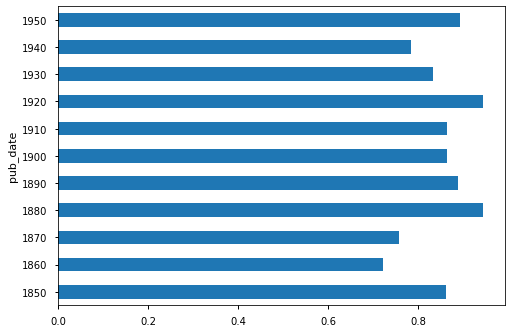

In [ ]:
fig = (
    test_df.groupby([test_df.pub_date.dt.year])["correct"]
    .agg("mean")
    .sort_index()
    .plot(kind="barh")
)

We can see that there is some difference in the performance on the test set for various years. This could be down to noise in the training process and data so we can't draw any hard conclusions from this small test, but it might be something we want to explore further. Since we also have the probabilities, lets see how the distribution of these compares when the label is correct for each year

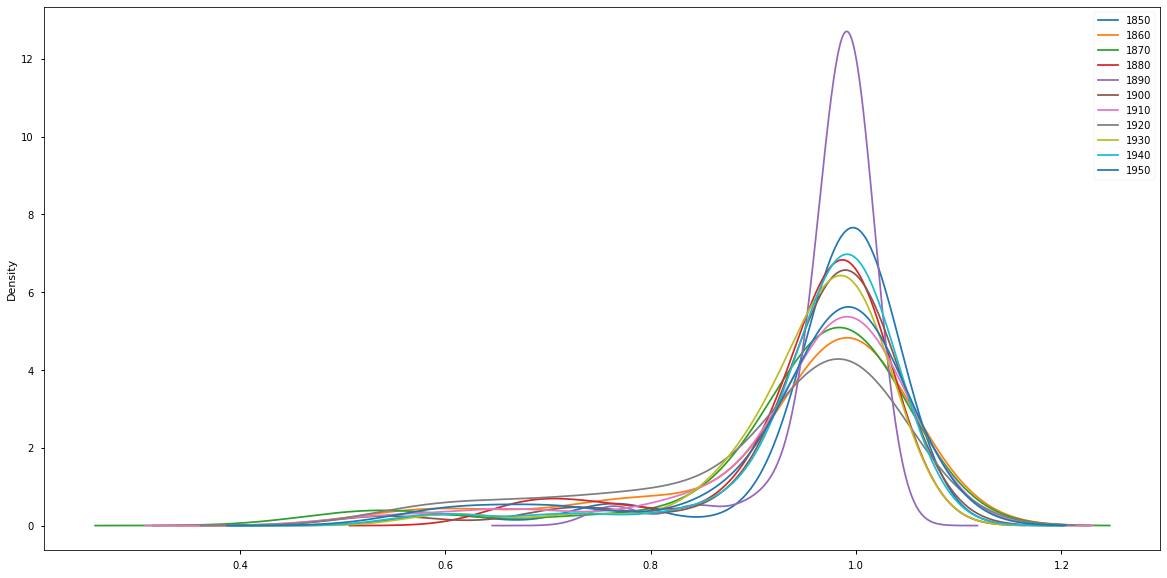

In [ ]:
ax = (
    test_df[test_df["label"] == pred_str]
    .groupby([test_df.pub_date.dt.year])["argmax_confidence"]
    .plot.kde(use_index=True, legend=True, figsize=(20, 10))
)

We see here that the distribution is fairly consistent across each year. We can also take a look at the distribution of confidence where the model was not correct

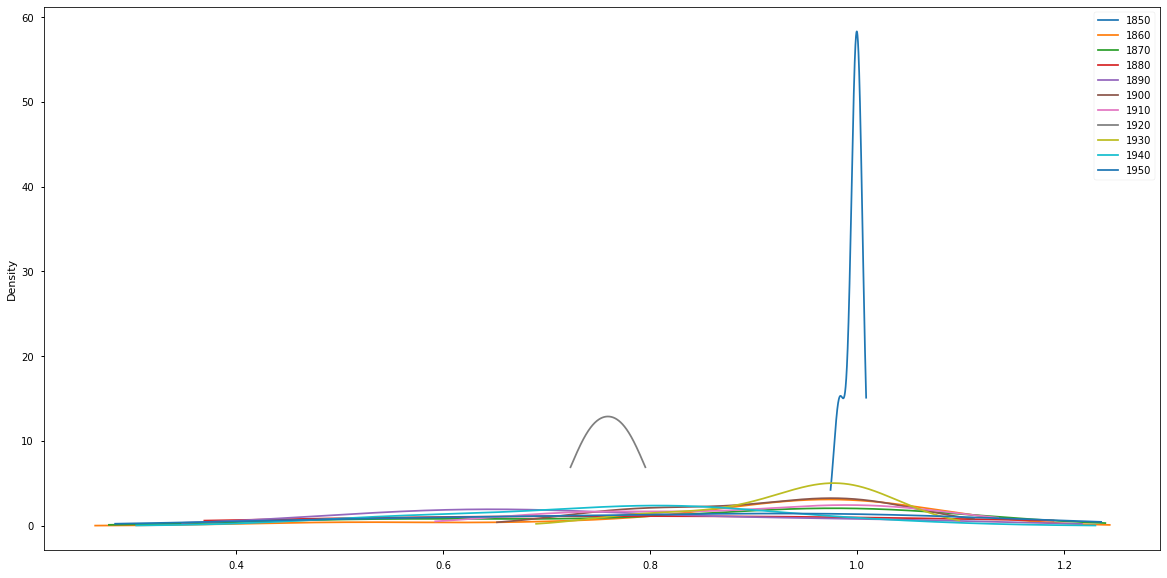

In [ ]:
ax = (
    test_df[test_df["label"] != pred_str]
    .groupby([test_df.pub_date.dt.year])["argmax_confidence"]
    .plot.kde(use_index=True, legend=True, figsize=(20, 10))
)

We can see that the argmax confidence distribution when the model made wrong predictions is much more varied. Let's check how many the model got wrong in total on the test set

In [ ]:
len(test_df[test_df["label"] != pred_str])

60

This is a pretty small number in total so once we have done our groubpy looking at the distribtuions is probably not particularly meaningul. Let's take a look for all years

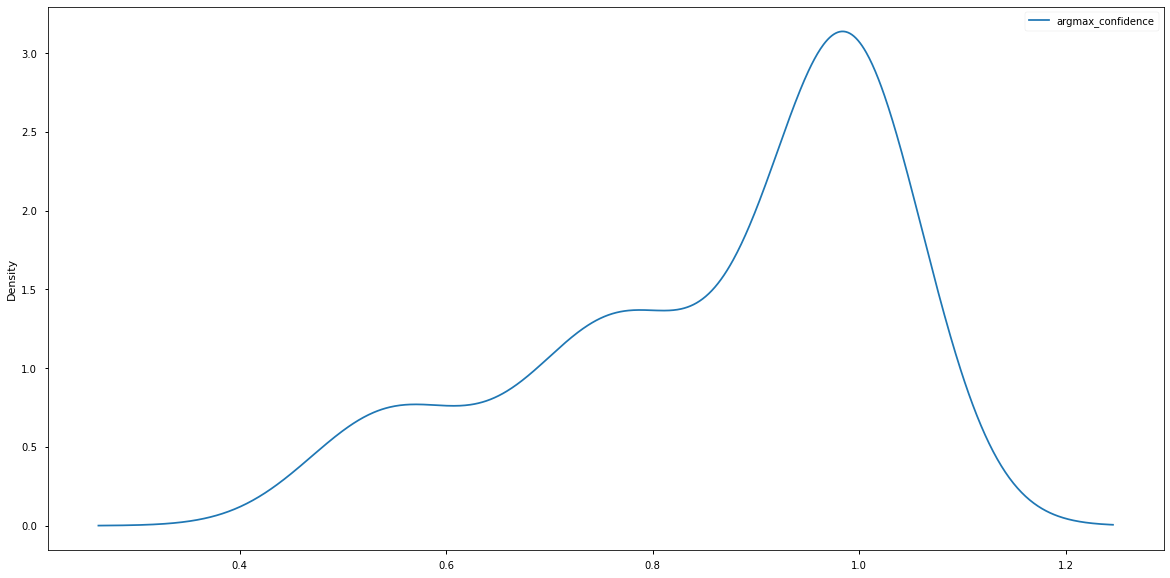

In [ ]:
ax = (
    test_df[test_df["label"] != pred_str]["argmax_confidence"]
    .plot.kde(use_index=True, legend=True, figsize=(20, 10))
)

### Summary

- more labels 
- kfold validation 
- run multiple runs/epochs 